# Objective
In this notebook, we want to extract dependency paths which can differentiate:
- A logical fallacy from other logical fallacies
- For-against and Perspective users for a given logical fallacy
- Top 10 vs. the rest of users for a given logical fallacy and a given debate type (for-against or perspective)

# Framework

We will use Jensen-Shannon divergence to extract these differentiating dependency paths.

# Notebook setup

In [1]:
# Mount Google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# Clone `CreateDebateScraper` library from github for handling
# CreateDebate dataset
!git clone https://github.com/utkarsh512/CreateDebateScraper.git
%cd CreateDebateScraper/src/nested/

Cloning into 'CreateDebateScraper'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 176 (delta 5), reused 4 (delta 4), pack-reused 170
Receiving objects: 100% (176/176), 207.95 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/CreateDebateScraper/src/nested


In [3]:
# Install `cpnet` library for core-periphery analysis
!pip install cpnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from thread import (Comment,
                    Thread)

from collections import deque
from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import networkx as nx
import spacy
import cpnet
import nltk 

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 5)

# Setup for nltk
nltk.download('punkt') # For tokenizers
nltk.download('stopwords')
nltk.download('wordnet') # For lemmatizers
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-13 19:45:50.469968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-13 19:45:50.470062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-13 19:45:50.470084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [30]:
# For caching objects to drive

def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def save_obj(obj, file_path):
    """Save an object to given path via pickling
    :param obj: Object to pickle
    :param file_path: Path for pickling
    :type file_path: string
    """
    with open(file_path, 'wb') as f:
        return pickle.dump(obj, f)

In [31]:
# Create a cache directory to cache temporary result (to avoid recomputation
# in case notebook gets disconnected)

cache_path = '/content/gdrive/MyDrive/DL/cache/70/{}'

!mkdir /content/gdrive/MyDrive/DL/cache/70

mkdir: cannot create directory ‘/content/gdrive/MyDrive/DL/cache/70’: File exists


# Load CreateDebate dataset

In [6]:
comments = dict()

# Topical forums on CreateDebate. We have scraped comments for all of the
# following forurm.
categories = ['business', 'comedy', 'entertainment', 'health', 'law', 'nsfw',
              'politics2', 'religion', 'science', 'shopping', 'sports',
              'technology', 'travel', 'world']

# However, we will be analyzing comments from selected forum only!
# These forum have at least 10k comments each.
categories_selected = ['politics2', 'religion', 'world', 
                       'science', 'law', 'technology']

for x in categories_selected:
    comments[x] = list()

In [7]:
# Loading comments from select forums

for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')

    # Get all the `Thread` objects pickled while scraping.
    threads = list()
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()

    # While classifying CreateDebate comments, we used comments as per author mode.
    # Hence, using the same mode to attach classification score with the comments.
    # 
    # score < 0.5 -> ad hominem comment
    #       > 0.5 -> non ad hominem comment
    authors = dict()
    for thread in threads:
        for k, v in thread.comments.items():
            try:
                authors[v.author].append((v, k))
            except:
                authors[v.author] = list()
                authors[v.author].append((v, k))

    ctr = 0
    # Load the classification score of the comments.
    with open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/comments_with_score.log', 'rb') as fp:
        cws = pickle.load(fp)
    # Attach classification score with the comments.
    for author in authors.keys():
        for i in range(len(authors[author])):
            comment, cid = authors[author][i]
            foo = deepcopy(comment.__dict__)
            foo['tag'] = cat
            foo['score'] = cws[ctr][0]
            foo['validation'] = cws[ctr][1][0]
            foo['id'] = int(cid[3:])
            comments[cat].append(foo)
            ctr += 1

100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


In [8]:
# Get all usernames in a list
user_list = set()

for category in categories_selected:
    for comment in comments[category]:
        user_list.add(comment['author'])

user_list = list(user_list)

# Utilities for Core-Periphery analysis

In [9]:
def build_graph(user_subset, threads, n1 = 0, n2 = 0):
    """
    Builds user network graph from hyper-parameters n1 and n2
    
    Inputs
    ------
    :param user_subset: list of users to consider, rest will be ignored
    :param threads: list containing `Thread`s of comment
    :param n1: threshold on number of level-1 comments
    :param n2: threshold on number of direct replies

    Output
    ------
    (
        author_map: dict,
        reverse_map: list,
        author_count: int, 
        graph: nx.DiGraph,
        matrix: list
    )
    """

    # Uses globally defined `threads` variable to construct this dictionary.
    # You may choose which categories to be included while building `threads`

    # key  : author name
    # value: count of level-1 comments
    athr = dict()

    for e in threads:
        if 'root' in e.metaL.keys():
            for key in e.metaL['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
        if 'root' in e.metaR.keys():
            for key in e.metaR['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
    
    # Filter those authors who satisfy the contraint on number of level-1 comments
    L1_athr = dict()
    for x in athr:
        if athr[x] >= n1:
            L1_athr[x] = True

    # Now use `athr` for storing count of direct replies
    # key  : author name
    # value: count of direct replies received
    athr = dict()

    # Depth-first search utility to get number of direct replies for each author
    def dfs(Map, cmntMap, athr, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs(Map[cid], cmntMap, athr, key)
            return

        cur_author = cmntMap[cid].author
        try:
            athr[cur_author] += len(Map[cid].keys())
        except:
            athr[cur_author] = len(Map[cid].keys())

        for key in Map[cid].keys():
            dfs(Map[cid], cmntMap, athr, key)

    # Traverse thread-tree to get number of direct replies for each author
    for e in threads:
        if 'root' in e.metaL.keys():
            dfs(e.metaL, e.comments, athr)
        if 'root' in e.metaR.keys():
            dfs(e.metaR, e.comments, athr) 
    
    # Filter authors who now satify both the contrainsts on count of 
    # - level-1 comments
    # - direct replies
    A = []
    for x in athr:
        if x not in user_subset:
            continue
        if athr[x] >= n2:
            try:
                z = L1_athr[x]
                A.append(x)
            except KeyError:
                pass

    # key  : author name
    # value: corresponing node number in the support/dispute network
    author_map = dict()

    # To get author name for node number
    reverse_map = ["" for _ in range(len(A))]
    author_count = len(A)

    for i in range(author_count):
        author_map[A[i]] = i
        reverse_map[i] = A[i]
    
    # Weighted adjacency matrices for user network
    # Weight for directed edge b/w Node A and Node B corresponsds to the number
    # of times Node A directly-replied Node B.
    matrix = [[0 for j in range(author_count)] for i in range(author_count)]

    # Depth-first search utility to build the adjacency matrices for graph.
    def dfs1(Map, cmntMap, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs1(Map[cid], cmntMap, key)
            return

        cur_author = cmntMap[cid].author
        
        if cur_author in author_map:
            cur_author_id = author_map[cur_author]
            for key in Map[cid].keys():
                nxt_author = cmntMap[key].author
                if nxt_author in author_map:
                    nxt_author_id = author_map[nxt_author]
                    matrix[nxt_author_id][cur_author_id] += 1

        for key in Map[cid].keys():
            dfs1(Map[cid], cmntMap, key)

    for e in threads:
        if 'root' in e.metaL:
            dfs1(e.metaL, e.comments)
        if 'root' in e.metaR:
            dfs1(e.metaR, e.comments)
        
    # Create NetworkX graphs from the adjacency matrices.
    # We need nx graphs in order to get various network stats provided in nx
    # library.
    graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if matrix[i][j] != 0:
                graph.add_weighted_edges_from([(i, j, matrix[i][j])])
    
    return (author_map, reverse_map, author_count, graph, matrix)

In [10]:
def get_coreness_dict(graph):
    """Get coreness value for each nodes as dictionary. We use Boyd algorithm.
    :param graph: `nx.DiGraph` object

    For more info about the algorithm used, see
    https://github.com/skojaku/core-periphery-detection
    """
    algorithm = cpnet.MINRES()
    algorithm.detect(graph)
    coreness = algorithm.get_coreness()
    return coreness        

# Utilities for Dependency Parsing

In [11]:
def load_empath_dictionary():
    """
    Returns a dict[str, list] object where keys are categories and values are 
    associated words for that category
    """
    empath_dict = dict()
    with open('/content/gdrive/MyDrive/DL/empath/dictionary.tsv', 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            name = cols[0]
            terms = cols[1:]
            empath_dict[name] = list()
            for t in set(terms):
                empath_dict[name].append(t)
    return empath_dict

In [12]:
empath_dict = load_empath_dictionary()

In [13]:
tokens_count = list()
for v in empath_dict.values():
    tokens_count.append(len(v))
print(f'Average token count {np.average(tokens_count)}, Std. dev {np.std(tokens_count)}')

Average token count 83.29381443298969, Std. dev 28.771070501829353


In [14]:
# SOTA slur word dictionary (from Punyajoy)
with open('/content/gdrive/MyDrive/DL/slurwords/slur_dictionary.json') as f:
    slur_words_dict = json.load(f)

In [15]:
# Hate-targets broad categories
# Paper: "A Measurement Study of Hate Speech in Social Media", Mainack Mondal
with open('/content/gdrive/MyDrive/DL/empath/hate_categories.json') as f:
    hate_targets_dict = json.load(f)
pprint(hate_targets_dict)

{'Behavior': ['negative_emotion',
              'timidity',
              'disappointment',
              'animal',
              'smell',
              'anger',
              'torment',
              'shame',
              'lust',
              'sadness',
              'rage',
              'dominant_personality',
              'violence',
              'childish',
              'pet',
              'irritability',
              'fear',
              'sexual',
              'ridicule',
              'wealthy',
              'weakness',
              'nervousness',
              'envy',
              'aggression',
              'hate'],
 'Class': ['economy', 'poor', 'stealing'],
 'Crime': ['prison', 'crime', 'terrorism'],
 'Disablity': ['mental'],
 'Ethnicity': ['immigrant', 'arabs', 'asians'],
 'Gender': ['women', 'feminine'],
 'Physical': ['monster',
              'ugliness',
              'youth',
              'appearance',
              'disgust',
              'hygiene',
        

In [16]:
hate_targets_raw = dict()
# key: hate_targets
# value: list of raw tokens associated with that target

for k, v in hate_targets_dict.items():
    hate_targets_raw[k] = list()
    for token_type in v:
        if token_type in slur_words_dict:
            hate_targets_raw[k].extend(slur_words_dict[token_type])
        if token_type in empath_dict:
            hate_targets_raw[k].extend(empath_dict[token_type])

In [17]:
lemmatizer = WordNetLemmatizer()
replace_underscores_with_whitespaces = lambda z: ' '.join(z.split('_'))

hate_targets = dict()
# key: hate_targets
# value: list of processed tokens associated with that target

for k, v in hate_targets_raw.items():
    temp = list(map(lemmatizer.lemmatize, v))
    hate_targets[k] = set(map(replace_underscores_with_whitespaces, temp))

# pprint(hate_targets)

In [18]:
def create_dependency_graph(doc):
    """Create dependency graph of tokens from scapy doc
    :param doc: scapy doc instance
    """
    dependency_edges = list() # (parent, child, relationship)
    id_to_text = dict()
    id_to_token = dict()
    root = None
    node_count = 0

    for token in doc:
        node_count += 1
        parent = token.head.i
        child = token.i
        relationship = token.dep_
        id_to_text[child] = lemmatizer.lemmatize(token.text)
        id_to_token[child] = token
        if relationship == 'ROOT':
            root = child
            continue
        dependency_edges.append((parent, child, relationship))

    dependency_graph = dict()
    for i in range(node_count): 
        dependency_graph[i] = list()
    for p, c, r in dependency_edges:
        dependency_graph[p].append((c, r))
        dependency_graph[c].append((p, r))
    
    return dependency_graph, id_to_text, id_to_token, root

In [19]:
def get_personal_pronoun_ids(id_to_token):
    """Index generator for personal pronouns"""
    for k, v in id_to_token.items():
        if v.tag_ == 'PRP': # Personal pronoun tag in scapy
            yield k

In [20]:
def get_pronoun_ids(id_to_token):
    """Index generator for pronouns"""
    for k, v in id_to_token.items():
        if v.pos_ == 'PRON': # Pronoun tag in scapy
            yield k

In [21]:
def get_trigger_ids(id_to_text, trigger_type):
    """Generates ids which are indices of triggers
    :param id_to_text: id_to_text returned by create_dependency_graph
    :type id_to_text: dict
    :param trigger_type: What type of triggers?
    :type trigger_type: str
    """
    for k, v in id_to_text.items():
        if v in hate_targets[trigger_type]:
            yield k

In [22]:
def breadth_first_search(dependency_graph, source):
    """Performs breadth first search
    :param dependency_graph: Dependency graph returned by create_dependency_graph
    :type dependency_graph: dict
    :param source: Source node ID
    :type source: int
    """
    q = deque()
    used = set()
    d = dict() # distance of nodes from source
    p = dict() # parent in bfs
    r = dict() # relation observed

    q.append(source)
    used.add(source)
    p[source] = -1
    d[source] = 0

    while len(q):
        v = q.popleft()
        for u, rel in dependency_graph[v]:
            if u in used:
                continue
            used.add(u)
            q.append(u)
            d[u] = d[v] + 1
            p[u] = v
            r[u] = rel

    return d, p, r

In [23]:
def generate_path_from_bfs(source, dest, dist_dict, parent_dict, relation_dict):
    """Generate path from source to dest. Path will contain relationships 
    encountered in bfs.
    """
    assert dist_dict[source] == 0
    assert dest in dist_dict 

    indices_list = list() # to store indices along the path

    path = list()
    cur = dest
    while cur != source:
        path.append(relation_dict[cur])
        indices_list.append(cur)
        cur = parent_dict[cur]
    indices_list.append(cur)
    
    path_string = ' -> '.join(path)
    return path_string, indices_list

In [24]:
def get_trigger_count(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = 0

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        trigger_count[trigger_type] += 1
    
    return trigger_count

In [25]:
def get_trigger_count_by_username_ctx(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = dict()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size,
                          as_tuples=True)

    for doc, context in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        if context['username'] in trigger_count[trigger_type]:
                            trigger_count[trigger_type][context['username']] += 1
                        else:
                            trigger_count[trigger_type][context['username']] = 1
    
    return trigger_count

In [26]:
def get_trigger_count_by_path(texts, index_generator, n_process=2, batch_size=1000):
    """Computes no. of occurence of dependency paths for given texts and returns it
    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """

    trigger_count = dict()
    # key: dependency path
    # value: no. of occurence of given dependency path in `texts`

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path, _ = generate_path_from_bfs(index, trigger_id, dist,
                                                         parent, relation)
                        if path in trigger_count:
                            trigger_count[path] += 1
                        else:
                            trigger_count[path] = 1
    
    return trigger_count

In [27]:
def get_words_along_paths(texts, index_generator, n_process=2, batch_size=1000):
    """For each dependency path encountered, it will store the actual words
    which exist as we traverse the path
    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """
    word_path = dict()
    # key: dependency path
    # value: list containing the actual words instead of relationship along the 
    #        dependency path

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path, word_indices = \
                            generate_path_from_bfs(index, trigger_id, dist,
                                                   parent, relation)
                        words = list()
                        for word_index in word_indices:
                            words.append(id_to_text[word_index])
                        words_string = ' -> '.join(words)

                        if path not in word_path:
                            word_path[path] = list()
                        word_path[path].append(words_string)             
    
    return word_path

In [28]:
def get_trigger_count_by_word_path(texts, index_generator, n_process=2, batch_size=1000):
    """Computes no. of occurence of word path (extracted from dependency paths)
    for given texts and returns it
    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """

    trigger_count = dict()
    # key: word path
    # value: no. of occurence of given dependency path in `texts`

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path, word_indices = \
                            generate_path_from_bfs(index, trigger_id, dist,
                                                   parent, relation)
                        words = list()
                        for word_index in word_indices:
                            words.append(id_to_text[word_index])
                        words_string = ' -> '.join(words)

                        if words_string in trigger_count:
                            trigger_count[words_string] += 1
                        else:
                            trigger_count[words_string] = 1
    
    return trigger_count

In [32]:
def get_comments_by_path(texts, index_generator, n_process=2, batch_size=1000):
    """For each dependency path encountered, it will store the actual words
    which exist as we traverse the path

    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """
    comment_list = list()

    comment_ids = dict()
    # key: dependency path
    # value: dict of <comment_pos, occurence of given dependency path in the given comment>

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        comment_list.append(doc.text)
        curr_comment_pos = len(comment_list) - 1
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path, word_indices = \
                            generate_path_from_bfs(index, trigger_id, dist,
                                                   parent, relation)
                        words = list()
                        for word_index in word_indices:
                            words.append(id_to_text[word_index])
                        words_string = ' -> '.join(words)
                        if path not in comment_ids:
                            comment_ids[path] = dict()
                        if curr_comment_pos not in comment_ids[path]:
                            comment_ids[path][curr_comment_pos] = list()
                        comment_ids[path][curr_comment_pos].append(words_string)
    
    return comment_ids, comment_list

In [33]:
def get_comments_by_word_path(texts, index_generator, n_process=2, batch_size=1000):
    """For each dependency path encountered, it will store the actual words
    which exist as we traverse the path

    :param texts: list of comment body (text)
    :param index_generator: `get_personal_pronoun_ids` or `get_pronoun_ids`
    :param n_process: No. of processes spawned for processing, refer to pipe utility in spacy
    :param batch_size: Batch size while processing, refer to pipe utility in spacy
    """
    comment_list = list()

    comment_ids = dict()
    # key: word dependency path
    # value: dictionary where
    #        key: comment_index in comment_list
    #        value: no. of times that comment contains this word path

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        comment_list.append(doc.text)
        curr_comment_pos = len(comment_list) - 1
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path, word_indices = \
                            generate_path_from_bfs(index, trigger_id, dist,
                                                   parent, relation)
                        words = list()
                        for word_index in word_indices:
                            words.append(id_to_text[word_index])
                        words_string = ' -> '.join(words)

                        if words_string not in comment_ids:
                            comment_ids[words_string] = dict()
                        if curr_comment_pos not in comment_ids[words_string]:
                            comment_ids[words_string][curr_comment_pos] = 0
                        comment_ids[words_string][curr_comment_pos] += 1
    
    return comment_ids, comment_list

# Utilities for Jensen Shannon divergence

In [34]:
def normalize_distribution(dist):
    """Normalize the values in dictionary `dist` such that its values sum to 1
    :param dist: Distribution of dependency path / word path
    :type dist: dict
    """
    new_dist = {}
    acc = 0
    for v in dist.values():
        acc += v
    for k, v in dist.items():
        new_dist[k] = v / acc
    return new_dist

In [62]:
def preprocess_for_kl_divergence(dist_list):
    """Preprocess distributions and create a universal distribution which is 
    the average of all the distribution
    """
    for i in range(len(dist_list)):
        dist_list[i] = normalize_distribution(dist_list[i])

    universal_dist = {}
    for dist in dist_list:
        for k, v in dist.items():
            if k not in universal_dist:
                universal_dist[k] = 0
            universal_dist[k] += v
    
    # Average
    avg_dist = {}
    for k, v in universal_dist.items():
        avg_dist[k] = v / len(dist_list)

    keys = list(avg_dist.keys())
    dist_probs = []
    for dist in dist_list:
        dist_prob = []
        for k in keys:
            if k not in dist:
                dist_prob.append(0)
            else:
                dist_prob.append(dist[k])
        dist_probs.append(dist_prob)
    
    univ_prob = []
    for k in keys:
        univ_prob.append(avg_dist[k])

    return keys, univ_prob, dist_probs

In [37]:
def log2(x):
    return np.log2(x) if x != 0 else 0

In [70]:
def order_paths_by_kl_score(keys, dist_prob, univ_prob):
    path_tuple = []
    for i in range(len(keys)):
        score = dist_prob[i] * log2(dist_prob[i] / univ_prob[i])
        path_tuple.append((keys[i], score, dist_prob[i], univ_prob[i]))
    path_tuple = sorted(path_tuple, key=lambda z: z[1], reverse=True)
    return path_tuple

In [75]:
def explain_path(path):
    path_list = path.split(' -> ')
    return ' -> '.join(list(map(spacy.explain, path_list)))

# Task 1

In [41]:
for_against_debates = dict()
perspective_debates = dict()

for cat in categories_selected:
    for_against_debates[cat] = list()
    perspective_debates[cat] = list()

    for comment in comments[cat]:
        if comment['polarity'] == 'Not Available':
            perspective_debates[cat].append(deepcopy(comment))
        else:
            for_against_debates[cat].append(deepcopy(comment))

In [42]:
# For now, only Politics users are considered!
for_against_user_set = set()
perspective_user_set = set()

for comment in for_against_debates['politics2']:
    for_against_user_set.add(comment['author'])

for comment in perspective_debates['politics2']:
    perspective_user_set.add(comment['author'])

print(f'{len(for_against_user_set)} & {len(perspective_user_set)}')

6761 & 2002


In [43]:
# Encoding labels used while classification.
# Refer to notebook#63.
label_map = {
    'faulty generalization': 0,
    'false causality': 1,
    'circular reasoning': 2, 
    'ad populum': 3,
    'ad hominem': 4,
    'fallacy of logic': 5,
    'appeal to emotion': 6,
    'false dilemma': 7,
    'equivocation': 8,
    'fallacy of extension': 9,
    'fallacy of relevance': 10,
    'fallacy of credibility': 11,
    'intentional': 12,
}

inverse_label_map = dict()
for k, v in label_map.items():
    inverse_label_map[v] = k

In [44]:
# Load labels and scores obtained during classification of for-against and
# perspective debates into the logical fallacies
for_against_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-for_against_labels_and_scores.pkl')
perspective_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-perspective_labels_and_scores.pkl')

In [45]:
for_against_logical = dict()
perspective_logical = dict()
# key: logical fallacy class
# value: list of comments 

for k in label_map.keys():
    for_against_logical[k] = list()
    perspective_logical[k] = list()

for comment, labels_and_scores in zip(for_against_debates['politics2'], for_against_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    for_against_logical[inverse_label_map[label]].append(comment)

for comment, labels_and_scores in zip(perspective_debates['politics2'], perspective_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    perspective_logical[inverse_label_map[label]].append(comment)

In [46]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization', 
                    'ad hominem', 
                    'intentional',
                    'appeal to emotion')

In [47]:
for_against_texts = dict()
perspective_texts = dict()

for k in classes_selected:
    for_against_texts[k] = [comment['body'].lower() for comment in for_against_logical[k]]
    perspective_texts[k] = [comment['body'].lower() for comment in perspective_logical[k]]

In [48]:
trigger_count_by_path_for_against = load_obj('/content/gdrive/MyDrive/Temp/69-trigger_count_by_path_for_against.pkl')
trigger_count_by_path_perspective = load_obj('/content/gdrive/MyDrive/Temp/69-trigger_count_by_path_perspective.pkl')

In [49]:
comment_ids_for_against  = load_obj('/content/gdrive/MyDrive/Temp/69-comment_ids_for_against.pkl')
comment_list_for_against = load_obj('/content/gdrive/MyDrive/Temp/69-comment_list_for_against.pkl')
comment_ids_perspective  = load_obj('/content/gdrive/MyDrive/Temp/69-comment_ids_perspective.pkl')
comment_list_perspective = load_obj('/content/gdrive/MyDrive/Temp/69-comment_list_perspective.pkl')

In [50]:
trigger_count_by_word_path_for_against = dict()
trigger_count_by_word_path_perspective = dict()

for k in classes_selected:
    trigger_count_by_word_path_for_against[k] = get_trigger_count_by_word_path(for_against_texts[k], get_personal_pronoun_ids)
    trigger_count_by_word_path_perspective[k] = get_trigger_count_by_word_path(perspective_texts[k], get_personal_pronoun_ids)

save_obj(trigger_count_by_word_path_for_against, '/content/gdrive/MyDrive/Temp/70-trigger_count_by_word_path_for_against.pkl')
save_obj(trigger_count_by_word_path_perspective, '/content/gdrive/MyDrive/Temp/70-trigger_count_by_word_path_perspective.pkl')

100%|██████████| 1335/1335 [00:12<00:00, 104.42it/s]


In [51]:
def reduce_array(a):
    d = {}
    for x in a:
        if x not in d:
            d[x] = 0
        d[x] += 1
    lst = []
    for k, v in d.items():
        lst.append((k, v))
    lst = sorted(lst, key=lambda z: z[1], reverse=True)
    s = []
    for k, v in lst:
        s.append(f'{k} (x{v}), ')
    return ''.join(s)

## For-against debates

In [95]:
# Dependency paths

dependency_path_score_for_against = {
    "score": [],
    "fallacy": [],
    "type": []
}

dependency_path_length_for_against = {
    "length": [],
    "fallacy": [],
    "type": []
}

logical_cls = []
dist_list = []

for k, v in trigger_count_by_path_for_against.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    print('Top 5 overused')
    for i in range(5):
        print(f'[{path_tuples[i][1] : .5f}] {explain_path(path_tuples[i][0])}')
        dependency_path_score_for_against['score'].append(path_tuples[i][1])
        dependency_path_score_for_against['type'].append('over-used')
        dependency_path_score_for_against['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        dependency_path_length_for_against['length'].append(path_length)
        dependency_path_length_for_against['type'].append('over-used')
        dependency_path_length_for_against['fallacy'].append(cls)

    print('\nTop 5 underused')
    for i in range(-1, -6, -1):
        print(f'[{path_tuples[i][1] : .5f}] {explain_path(path_tuples[i][0])}')
        dependency_path_score_for_against['score'].append(path_tuples[i][1])
        dependency_path_score_for_against['type'].append('under-used')
        dependency_path_score_for_against['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        dependency_path_length_for_against['length'].append(path_length)
        dependency_path_length_for_against['type'].append('under-used')
        dependency_path_length_for_against['fallacy'].append(cls)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance

Top 5 overused
[ 0.00199] nominal subject -> clausal complement -> nominal subject
[ 0.00164] direct object -> nominal subject
[ 0.00129] direct object -> open clausal complement -> nominal subject
[ 0.00112] object of preposition -> prepositional modifier -> clausal complement -> nominal subject
[ 0.00112] nominal subject -> clausal complement -> clausal complement -> nominal subject

Top 5 underused
[-0.00291] nominal subject
[-0.00264] attribute -> nominal subject
[-0.00249] direct object
[-0.00179] adjectival modifier -> attribute -> nominal subject
[-0.00151] adverbial clause modifier -> nominal subject

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization

Top 5 overused
[ 0.00225] nominal subject -> adverbial clause modifier -> nominal subject
[ 0.00104] nominal subject -> clausal compl

In [96]:
# Word paths

word_path_score_for_against = {
    "score": [],
    "fallacy": [],
    "type": []
}

word_path_length_for_against = {
    "length": [],
    "fallacy": [],
    "type": []
}

logical_cls = []
dist_list = []

for k, v in trigger_count_by_word_path_for_against.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    print('Top 5 overused')
    for i in range(5):
        print(f'[{path_tuples[i][1] : .5f}] {path_tuples[i][0]}')
        word_path_score_for_against['score'].append(path_tuples[i][1])
        word_path_score_for_against['type'].append('over-used')
        word_path_score_for_against['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        word_path_length_for_against['length'].append(path_length)
        word_path_length_for_against['type'].append('over-used')
        word_path_length_for_against['fallacy'].append(cls)

    print('\nTop 5 underused')
    for i in range(-1, -6, -1):
        print(f'[{path_tuples[i][1] : .5f}] {path_tuples[i][0]}')
        word_path_score_for_against['score'].append(path_tuples[i][1])
        word_path_score_for_against['type'].append('under-used')
        word_path_score_for_against['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        word_path_length_for_against['length'].append(path_length)
        word_path_length_for_against['type'].append('under-used')
        word_path_length_for_against['fallacy'].append(cls)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance

Top 5 overused
[ 0.00037] mean -> i
[ 0.00036] mean -> you
[ 0.00036] kill -> is -> guess -> i
[ 0.00035] feel -> i
[ 0.00031] law -> have -> we

Top 5 underused
[-0.00041] kill -> you
[-0.00027] feel -> you
[-0.00023] stupid -> are -> you
[-0.00020] kill -> them
[-0.00019] hate -> you

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization

Top 5 overused
[ 0.00035] mean -> i
[ 0.00029] stupid -> know -> stupid -> know -> he
[ 0.00026] kill -> they
[ 0.00024] enemy -> are -> they
[ 0.00024] kill -> u

Top 5 underused
[-0.00036] care -> i
[-0.00030] feel -> i
[-0.00028] feel -> you
[-0.00028] mean -> you
[-0.00024] stupid -> are -> you

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ad hominem

Top 5 overused
[ 0.00152] stupid -> are -> you


## Perspective debates

In [97]:
# Dependency paths

dependency_path_score_perspective = {
    "score": [],
    "fallacy": [],
    "type": []
}

dependency_path_length_perspective = {
    "length": [],
    "fallacy": [],
    "type": []
}

logical_cls = []
dist_list = []

for k, v in trigger_count_by_path_perspective.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    print('Top 5 overused')
    for i in range(5):
        print(f'[{path_tuples[i][1] : .5f}] {explain_path(path_tuples[i][0])}')
        dependency_path_score_perspective['score'].append(path_tuples[i][1])
        dependency_path_score_perspective['type'].append('over-used')
        dependency_path_score_perspective['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        dependency_path_length_perspective['length'].append(path_length)
        dependency_path_length_perspective['type'].append('over-used')
        dependency_path_length_perspective['fallacy'].append(cls)

    print('\nTop 5 underused')
    for i in range(-1, -6, -1):
        print(f'[{path_tuples[i][1] : .5f}] {explain_path(path_tuples[i][0])}')
        dependency_path_score_perspective['score'].append(path_tuples[i][1])
        dependency_path_score_perspective['type'].append('under-used')
        dependency_path_score_perspective['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        dependency_path_length_perspective['length'].append(path_length)
        dependency_path_length_perspective['type'].append('under-used')
        dependency_path_length_perspective['fallacy'].append(cls)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance

Top 5 overused
[ 0.00424] nominal subject -> clausal complement -> nominal subject
[ 0.00116] attribute -> clausal complement -> nominal subject
[ 0.00111] adjectival complement -> clausal complement -> nominal subject
[ 0.00109] direct object -> clausal complement -> nominal subject
[ 0.00103] object of preposition -> prepositional modifier -> clausal complement -> nominal subject

Top 5 underused
[-0.00283] nominal subject
[-0.00238] attribute -> nominal subject
[-0.00229] direct object
[-0.00157] adverbial clause modifier -> nominal subject
[-0.00125] object of preposition -> prepositional modifier -> conjunct -> nominal subject

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization

Top 5 overused
[ 0.00179] object of preposition -> prepositional modifier -> direct object -> adverbial claus

In [98]:
# Word paths

word_path_score_perspective = {
    "score": [],
    "fallacy": [],
    "type": []
}

word_path_length_perspective = {
    "length": [],
    "fallacy": [],
    "type": []
}

logical_cls = []
dist_list = []

for k, v in trigger_count_by_word_path_perspective.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    print('Top 5 overused')
    for i in range(5):
        print(f'[{path_tuples[i][1] : .5f}] {path_tuples[i][0]}')
        word_path_score_perspective['score'].append(path_tuples[i][1])
        word_path_score_perspective['type'].append('over-used')
        word_path_score_perspective['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        word_path_length_perspective['length'].append(path_length)
        word_path_length_perspective['type'].append('over-used')
        word_path_length_perspective['fallacy'].append(cls)

    print('\nTop 5 underused')
    for i in range(-1, -6, -1):
        print(f'[{path_tuples[i][1] : .5f}] {path_tuples[i][0]}')
        word_path_score_perspective['score'].append(path_tuples[i][1])
        word_path_score_perspective['type'].append('under-used')
        word_path_score_perspective['fallacy'].append(cls)
        path_length = len(path_tuples[i][0].split(' -> '))
        word_path_length_perspective['length'].append(path_length)
        word_path_length_perspective['type'].append('under-used')
        word_path_length_perspective['fallacy'].append(cls)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance

Top 5 overused
[ 0.00073] mean -> you
[ 0.00058] mean -> i
[ 0.00049] authority -> have -> you
[ 0.00047] kill -> me
[ 0.00044] law -> had -> had -> we

Top 5 underused
[-0.00029] stupid -> are -> you
[-0.00027] kill -> them
[-0.00024] hate -> you
[-0.00020] accuse -> you
[-0.00018] hate -> i

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization

Top 5 overused
[ 0.00183] law -> of -> one -> pas -> worked -> we
[ 0.00104] nation -> law -> of -> one -> pas -> worked -> we
[ 0.00104] fight -> led -> ’s -> worked -> we
[ 0.00091] cow -> have -> you
[ 0.00069] kill -> themselves

Top 5 underused
[-0.00046] feel -> i
[-0.00032] mean -> you
[-0.00029] mean -> it
[-0.00024] hate -> you
[-0.00024] kill -> them

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [99]:
palette = {
    'fallacy of relevance': 'tab:blue',
    'faulty generalization': 'tab:green',
    'ad hominem': 'tab:orange',
    'intentional': 'tab:red',
    'appeal to emotion': 'tab:purple'
}

In [111]:
def plot_dependency_path_score():
    fig, axes = plt.subplots(1, 2, sharey=True)
    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)
    sns.barplot(data=dependency_path_score_for_against, x='fallacy', y='score', hue='type', ax=axes[0])
    sns.barplot(data=dependency_path_score_perspective, x='fallacy', y='score', hue='type', ax=axes[1])

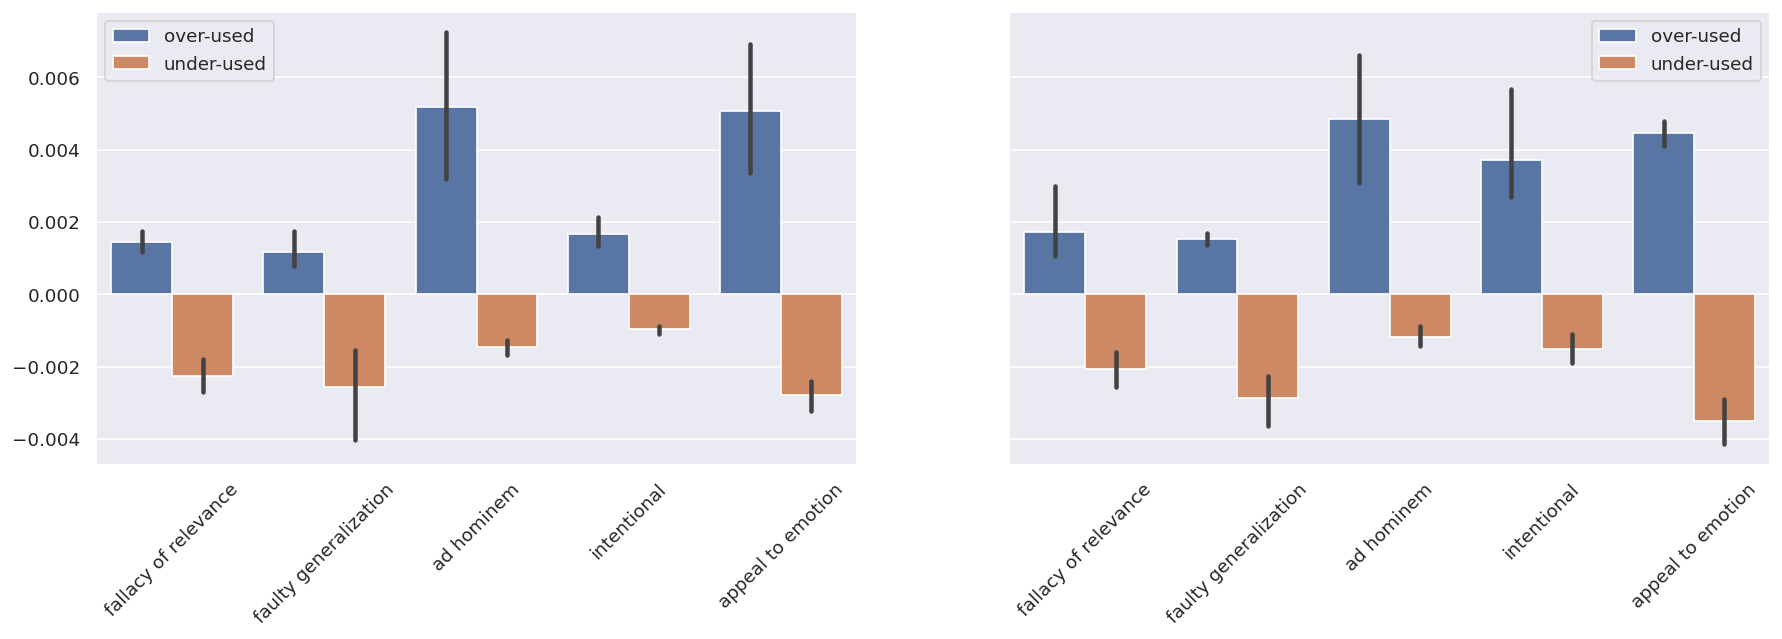

In [112]:
plot_dependency_path_score()

## Comments 

In [117]:
overused = {
    'for-against': dict(),
    'perspective': dict()
}

underused = {
    'for-against': dict(),
    'perspective': dict()
}

In [118]:
logical_cls = []
dist_list = []

for k, v in trigger_count_by_path_for_against.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    overused['for-against'][cls] = dict()
    underused['for-against'][cls] = dict()

    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    for i in range(5):
        path = path_tuples[i][0]
        detailed_path = explain_path(path)
        overused['for-against'][cls][detailed_path] = list()
        # Get top 5 comments
        comment_ids_list = list()
        for k, v in comment_ids_for_against[cls][path].items():
            comment_ids_list.append((k, len(v)))
        comment_ids_list = sorted(comment_ids_list, key=lambda z: z[1], reverse=True)

        filtered_cids = list()
        for cid, _ in comment_ids_list:
            cur_comment_text = comment_list_for_against[cls][cid]
            if (len(cur_comment_text.split()) > 200):
                continue
            filtered_cids.append(cid)

        for cid in filtered_cids[:5]:
            comment_body = comment_list_for_against[cls][cid]
            comment_triggers = reduce_array(comment_ids_for_against[cls][path][cid])
            overused['for-against'][cls][detailed_path].append(dict(comment=comment_body, path=comment_triggers))

    for i in range(-1, -6, -1):
        path = path_tuples[i][0]
        detailed_path = explain_path(path)
        underused['for-against'][cls][detailed_path] = list()
        # Get top 5 comments
        comment_ids_list = list()
        for k, v in comment_ids_for_against[cls][path].items():
            comment_ids_list.append((k, len(v)))
        comment_ids_list = sorted(comment_ids_list, key=lambda z: z[1], reverse=True)

        filtered_cids = list()
        for cid, _ in comment_ids_list:
            cur_comment_text = comment_list_for_against[cls][cid]
            if (len(cur_comment_text.split()) > 200):
                continue
            filtered_cids.append(cid)

        for cid in filtered_cids[:5]:
            comment_body = comment_list_for_against[cls][cid]
            comment_triggers = reduce_array(comment_ids_for_against[cls][path][cid])
            underused['for-against'][cls][detailed_path].append(dict(comment=comment_body, path=comment_triggers))


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ad hominem


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

intentional


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

appeal to emotion



In [119]:
logical_cls = []
dist_list = []

for k, v in trigger_count_by_path_perspective.items():
    logical_cls.append(k)
    dist_list.append(v)

keys, univ_prob, dist_probs = preprocess_for_kl_divergence(dist_list)

for index, cls in enumerate(logical_cls):
    overused['perspective'][cls] = dict()
    underused['perspective'][cls] = dict()

    print('\n' +'+' * 100 + '\n')
    print(cls + '\n')
    path_tuples = order_paths_by_kl_score(keys, dist_probs[index], univ_prob)

    for i in range(5):
        path = path_tuples[i][0]
        detailed_path = explain_path(path)
        overused['perspective'][cls][detailed_path] = list()
        # Get top 5 comments
        comment_ids_list = list()
        for k, v in comment_ids_perspective[cls][path].items():
            comment_ids_list.append((k, len(v)))
        comment_ids_list = sorted(comment_ids_list, key=lambda z: z[1], reverse=True)

        filtered_cids = list()
        for cid, _ in comment_ids_list:
            cur_comment_text = comment_list_perspective[cls][cid]
            if (len(cur_comment_text.split()) > 200):
                continue
            filtered_cids.append(cid)

        for cid in filtered_cids[:5]:
            comment_body = comment_list_perspective[cls][cid]
            comment_triggers = reduce_array(comment_ids_perspective[cls][path][cid])
            overused['perspective'][cls][detailed_path].append(dict(comment=comment_body, path=comment_triggers))

    for i in range(-1, -6, -1):
        path = path_tuples[i][0]
        detailed_path = explain_path(path)
        underused['perspective'][cls][detailed_path] = list()
        # Get top 5 comments
        comment_ids_list = list()
        for k, v in comment_ids_perspective[cls][path].items():
            comment_ids_list.append((k, len(v)))
        comment_ids_list = sorted(comment_ids_list, key=lambda z: z[1], reverse=True)

        filtered_cids = list()
        for cid, _ in comment_ids_list:
            cur_comment_text = comment_list_perspective[cls][cid]
            if (len(cur_comment_text.split()) > 200):
                continue
            filtered_cids.append(cid)

        for cid in filtered_cids[:5]:
            comment_body = comment_list_perspective[cls][cid]
            comment_triggers = reduce_array(comment_ids_perspective[cls][path][cid])
            underused['perspective'][cls][detailed_path].append(dict(comment=comment_body, path=comment_triggers))


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

fallacy of relevance


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

faulty generalization


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ad hominem


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

intentional


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

appeal to emotion



In [120]:
with open('./overused-path-comment.json', 'w') as f:
    json.dump(overused, f, indent=4)

with open('./underused-path-comment.json', 'w') as f:
    json.dump(underused, f, indent=4)